In [12]:
import numpy as np

from keras.preprocessing import sequence
import keras.models as km
import keras.layers as kl
import keras.constraints as kc
from keras.datasets import imdb
from keras import losses

import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as ipw

import data_preparation as mdp
from mercari_config import MercariConfig

In [13]:
num_words_item_desc = MercariConfig.MAX_WORDS_FROM_INDEX_4_ITEM_DESC + MercariConfig.WORD_I
max_seq_len_item_desc = MercariConfig.MAX_WORDS_IN_ITEM_DESC + 1 # Remember: first word is always <START>
embedding_dims = 32

num_words_name = MercariConfig.MAX_WORDS_FROM_INDEX_4_NAME + MercariConfig.WORD_I
max_seq_len_name = MercariConfig.MAX_WORDS_IN_NAME + 1 # Remember: first word is always <START>

batch_size = 200

In [14]:
%%time

train_data = mdp.load_data(MercariConfig.TRAINING_SET_PREP_FILE)
X_item_desc_seq_train = train_data[['id' + str(i) for i in range(max_seq_len_item_desc)]].as_matrix()
X_name_seq_train = train_data[['nm' + str(i) for i in range(max_seq_len_name)]].as_matrix()
x_cat_train = train_data['category_id'].as_matrix()
x_brand_train = train_data['brand_id'].as_matrix()
x_f_train = train_data[['item_condition_id', 'shipping']].as_matrix()
y_train = train_data['price'].as_matrix()

CPU times: user 6.83 s, sys: 616 ms, total: 7.44 s
Wall time: 7.37 s


In [15]:
print(X_item_desc_seq_train.shape, X_name_seq_train.shape, 
      x_cat_train.shape, x_brand_train.shape, x_f_train.shape, y_train.shape)

(237205, 301) (237205, 21) (237205,) (237205,) (237205, 2) (237205,)


In [16]:
%%time

val_data = mdp.load_data(MercariConfig.VALIDATION_SET_PREP_FILE)
X_item_desc_seq_val = val_data[['id' + str(i) for i in range(max_seq_len_item_desc)]].as_matrix()
X_name_seq_val = val_data[['nm' + str(i) for i in range(max_seq_len_name)]].as_matrix()
x_cat_val = val_data['category_id'].as_matrix()
x_brand_val = val_data['brand_id'].as_matrix()
x_f_val = val_data[['item_condition_id', 'shipping']].as_matrix()
y_val = val_data['price'].as_matrix()

CPU times: user 1.7 s, sys: 80 ms, total: 1.78 s
Wall time: 1.76 s


In [17]:
print(X_item_desc_seq_val.shape, X_name_seq_val.shape, 
      x_cat_val.shape, x_brand_val.shape, x_f_val.shape, y_val.shape)

(59302, 301) (59302, 21) (59302,) (59302,) (59302, 2) (59302,)


In [18]:
%%time

X_item_desc_seq_train = sequence.pad_sequences(
    X_item_desc_seq_train, maxlen=max_seq_len_item_desc, padding='post', truncating='post')
X_name_seq_train = sequence.pad_sequences(
    X_name_seq_train, maxlen=max_seq_len_name, padding='post', truncating='post')

X_item_desc_seq_val = sequence.pad_sequences(
    X_item_desc_seq_val, maxlen=max_seq_len_item_desc, padding='post', truncating='post')
X_name_seq_val = sequence.pad_sequences(
    X_name_seq_val, maxlen=max_seq_len_name, padding='post', truncating='post')

CPU times: user 3.47 s, sys: 264 ms, total: 3.73 s
Wall time: 3.7 s


In [19]:
feature_input = kl.Input(shape=(2,), name='feature_input')
category_input = kl.Input(shape=(1,), name='category_input')
brand_input = kl.Input(shape=(1,), name='brand_input')
item_desc_input = kl.Input(shape=(max_seq_len_item_desc,), name='item_desc_input')
name_input = kl.Input(shape=(max_seq_len_name,), name='name_input')

item_desc_embedding = kl.Embedding(num_words_item_desc, embedding_dims, name='item_desc_embedding')
item_desc_embedding_dropout = kl.SpatialDropout1D(0.5, name='item_desc_embedding_dropout')
item_desc_lstm_1 = kl.CuDNNLSTM(units=200, name='item_desc_lstm_1', return_sequences=True)
item_desc_lstm_2 = kl.CuDNNLSTM(units=200, name='item_desc_lstm_2')
item_desc_lstm_dropout = kl.Dropout(0.5, name='item_desc_lstm_dropout')

name_embedding = kl.Embedding(num_words_name, embedding_dims, name='name_embedding')
name_embedding_dropout = kl.SpatialDropout1D(0.5, name='name_embedding_dropout')
name_lstm_1 = kl.CuDNNLSTM(units=100, name='name_lstm_1', return_sequences=True)
name_lstm_2 = kl.CuDNNLSTM(units=100, name='name_lstm_2')
name_lstm_dropout = kl.Dropout(0.5, name='name_lstm_dropout')

category_embedding = kl.Embedding(1105, 10, name='category_embedding')
category_reshape = kl.Reshape(target_shape=(10,), name='category_reshape')

brand_embedding = kl.Embedding(2774, 10, name='brand_embedding')
brand_reshape = kl.Reshape(target_shape=(10,), name='brand_reshape')

input_fusion = kl.Concatenate(axis=1, name='input_fusion')
fusion_dense_1 = kl.Dense(400, activation='relu', name='fusion_dense_1')
fusion_dense_2 = kl.Dense(200, activation='relu', name='fusion_dense_2')
fusion_dense_3 = kl.Dense(1, activation='relu', name='fusion_dense_3')

item_desc_output = item_desc_embedding(item_desc_input)
item_desc_output = item_desc_embedding_dropout(item_desc_output)
item_desc_output = item_desc_lstm_1(item_desc_output)
item_desc_output = item_desc_lstm_2(item_desc_output)
item_desc_output = item_desc_lstm_dropout(item_desc_output)

name_output = name_embedding(name_input)
name_output = name_embedding_dropout(name_output)
name_output = name_lstm_1(name_output)
name_output = name_lstm_2(name_output)
name_output = name_lstm_dropout(name_output)

category_output = category_embedding(category_input)
category_output = category_reshape(category_output)

brand_output = brand_embedding(brand_input)
brand_output = brand_reshape(brand_output)

output = input_fusion([name_output, item_desc_output, category_output, brand_output, feature_input])
output = fusion_dense_1(output)
output = fusion_dense_2(output)
prediction = fusion_dense_3(output)

model = km.Model(inputs=[feature_input, category_input, brand_input, name_input, item_desc_input], outputs=prediction)

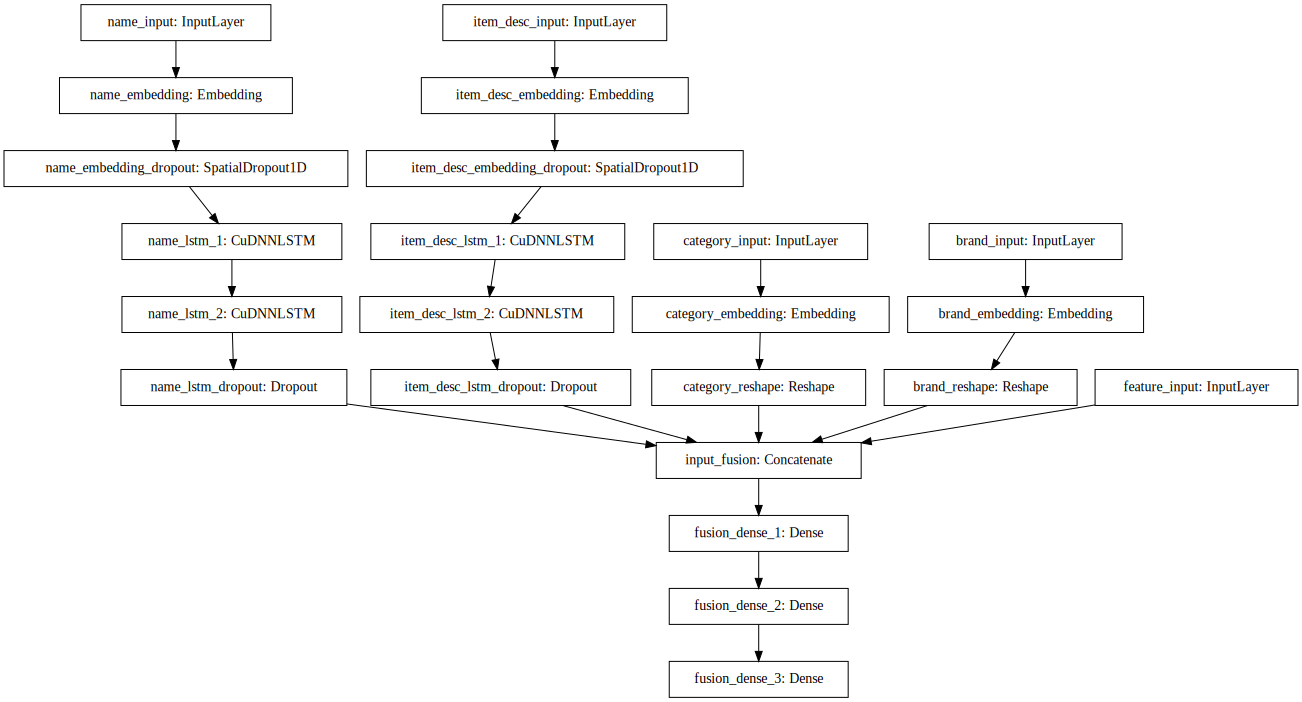

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_input (InputLayer)         (None, 21)           0                                            
__________________________________________________________________________________________________
item_desc_input (InputLayer)    (None, 301)          0                                            
__________________________________________________________________________________________________
name_embedding (Embedding)      (None, 21, 32)       1280256     name_input[0][0]                 
__________________________________________________________________________________________________
item_desc_embedding (Embedding) (None, 301, 32)      1280256     item_desc_input[0][0]            
__________________________________________________________________________________________________
name_embed

In [ ]:
from keras import backend as K

def root_mean_squared_logarithmic_error(y_true, y_pred):
    ret = losses.mean_squared_logarithmic_error(y_true, y_pred)
    return K.sqrt(ret)

def root_mean_squared_error(y_true, y_pred):
    ret = losses.mean_squared_error(y_true, y_pred)
    return K.sqrt(ret)

model.compile(optimizer='adam', loss=root_mean_squared_logarithmic_error, metrics=[root_mean_squared_error])

history_simple = model.fit(
    [x_f_train, x_cat_train, x_brand_train, X_name_seq_train, X_item_desc_seq_train], y_train,
    batch_size=batch_size,
    epochs=10,
    shuffle=True,
    validation_data=[[x_f_val, x_cat_val, x_brand_val, X_name_seq_val, X_item_desc_seq_val], y_val])

Train on 237205 samples, validate on 59302 samples
Epoch 1/10
237205/237205 [==============================] - 364s 2ms/step - loss: 0.4701 - root_mean_squared_error: 13.5068 - val_loss: 0.4509 - val_root_mean_squared_error: 13.1759
Epoch 2/10
237205/237205 [==============================] - 366s 2ms/step - loss: 0.4243 - root_mean_squared_error: 12.5300 - val_loss: 0.4160 - val_root_mean_squared_error: 12.3076
Epoch 3/10
237205/237205 [==============================] - 366s 2ms/step - loss: 0.4113 - root_mean_squared_error: 12.2252 - val_loss: 0.4171 - val_root_mean_squared_error: 12.2400
Epoch 4/10
237205/237205 [==============================] - 366s 2ms/step - loss: 0.4039 - root_mean_squared_error: 12.0314 - val_loss: 0.4060 - val_root_mean_squared_error: 12.0597
Epoch 5/10
207600/237205 [=========================>....] - ETA: 42s - loss: 0.3973 - root_mean_squared_error: 11.8317